# Getting Started with brmspy

This notebook demonstrates how to use **brmspy** - a Pythonic interface to the brms R package.

**brmspy v0.1.0** features:
- CmdStanPy backend (official Stan interface)
- Explicit brms version control
- Support for multiple inference methods (MCMC, VI, optimization)
- Python 3.8+ compatibility

## Setup

This notebook works in two scenarios:
1. **Installed package**: `pip install brmspy`
2. **Cloned repository**: Running from repository root

In [1]:
# Import brmspy - works for both installed package and cloned repo
import sys
import os

try:
    # Try importing as installed package
    import brmspy
    print(f"✓ Using installed brmspy {brmspy.__version__}")
except ImportError:
    # Fall back to importing from cloned repo
    # Add parent directory to path (assumes running from examples/)
    repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
    
    try:
        import brmspy
        print(f"✓ Using brmspy from repository: {repo_root}")
        print(f"  Version: {brmspy.__version__}")
    except ImportError as e:
        print("✗ Could not import brmspy!")
        print("  Please either:")
        print("  1. Install: pip install brmspy")
        print("  2. Or run from repository root with: jupyter notebook examples/getting_started.ipynb")
        raise

# Import other required packages
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("Setup complete!")
print("="*60)

Error importing in API mode: ImportError("dlopen(/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


✓ Using brmspy from repository: /Users/sebastian/PycharmProjects/pybrms
  Version: 0.1.0

Setup complete!


## 1. First Time Setup (One-Time Only)

Install brms R package and CmdStan compiler. This only needs to be done once per environment.

In [2]:
# Check if brms and CmdStan are already installed
try:
    version = brmspy.get_brms_version()
    print(f"✓ brms already installed (version {version})")
    
    import cmdstanpy
    cmdstan_path = cmdstanpy.cmdstan_path()
    print(f"✓ CmdStan already installed at: {cmdstan_path}")
    print("\nSkipping installation - already set up!")
    
except Exception as e:
    print("Installing brms and CmdStan...")
    print("This may take a few minutes on first run.")
    print("")
    
    # Install both brms and CmdStan
    brmspy.install_brms()
    
    print("\n" + "="*60)
    print("Installation complete!")
    print("="*60)

✓ brms already installed (version 1.2.22)
✓ CmdStan already installed at: /Users/sebastian/.cmdstan/cmdstan-2.37.0

Skipping installation - already set up!


## 2. Load Example Data

brmspy provides access to all datasets included in the brms package.

In [3]:
# Load the epilepsy dataset
epilepsy = brmspy.get_brms_data("epilepsy")

print("Epilepsy Dataset")
print("="*60)
print(f"Shape: {epilepsy.shape}")
print(f"\nColumns: {', '.join(epilepsy.columns)}")
print(f"\nFirst few rows:")
epilepsy.head()

Epilepsy Dataset
Shape: (236, 9)

Columns: Age, Base, Trt, patient, visit, count, obs, zAge, zBase

First few rows:


,Age,Base,Trt,patient,visit,count,obs,zAge,zBase
0,31.0,11.0,0,1,1,5.0,1,0.424995,-0.757173
1,30.0,11.0,0,2,1,3.0,2,0.265284,-0.757173
2,25.0,6.0,0,3,1,2.0,3,-0.533274,-0.944403
3,36.0,8.0,0,4,1,4.0,4,1.223553,-0.869511
4,22.0,66.0,0,5,1,7.0,5,-1.012408,1.302363


In [4]:
# Quick data exploration
print("Data Summary")
print("="*60)
print(epilepsy.describe())

print("\nTarget Variable Distribution (count):")
print(epilepsy['count'].value_counts().sort_index().head(10))

Data Summary
              Age        Base       count          zAge         zBase
count  236.000000  236.000000  236.000000  2.360000e+02  2.360000e+02
mean    28.338983   31.220339    8.254237  1.768830e-16 -3.387121e-17
std      6.261290   26.705051   12.346891  1.000000e+00  1.000000e+00
min     18.000000    6.000000    0.000000 -1.651255e+00 -9.444033e-01
25%     23.000000   12.000000    2.750000 -8.526970e-01 -7.197267e-01
50%     28.000000   22.000000    4.000000 -5.413949e-02 -3.452657e-01
75%     32.000000   41.000000    9.000000  5.847065e-01  3.662102e-01
max     42.000000  151.000000  102.000000  2.181822e+00  4.485281e+00

Target Variable Distribution (count):
count
0.0    23
1.0    16
2.0    20
3.0    33
4.0    29
5.0    17
6.0    14
7.0    13
8.0    11
9.0     5
Name: count, dtype: int64


## 3. Fit a Simple Model

Let's fit a Poisson regression model with random effects.

**Model:** `count ~ zAge + zBase * Trt + (1|patient)`

This model includes:
- Fixed effects: `zAge`, `zBase`, `Trt` and their interaction
- Random effect: varying intercepts by patient

In [ ]:
print("Fitting Bayesian Poisson regression model...")

model = brmspy.fit(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    data=epilepsy,
    family="poisson",
    warmup=500,
    iter=1000,
    chains=4
)
idata = model.idata

print("Model fitting complete!")

Fitting Bayesian Poisson regression model...


R callback write-console: Compiling Stan program...
  


Fitting model with brms (backend: cmdstanr)...


R callback write-console: Start sampling
  


Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 1.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

## 4. Examine Results

View the posterior summary statistics.

In [6]:
# Get summary statistics
summary = az.summary(
    idata,
    hdi_prob=0.95,
    kind="stats",
    round_to=3
)

print("Posterior Summary")
print("="*60)
print(summary)


Posterior Summary
                           mean     sd  hdi_2.5%  hdi_97.5%
b_Intercept               1.774  0.120     1.532      2.009
b_zAge                    0.090  0.092    -0.092      0.269
b_zBase                   0.683  0.122     0.436      0.915
b_Trt1                   -0.271  0.163    -0.562      0.073
b_zBase:Trt1              0.071  0.163    -0.276      0.374
...                         ...    ...       ...        ...
r_patient[7,Intercept]   -0.208  0.278    -0.822      0.283
r_patient[8,Intercept]    0.622  0.256     0.071      1.083
r_patient[9,Intercept]   -0.004  0.257    -0.551      0.462
lprior                   -3.184  0.009    -3.203     -3.168
lp__                   -700.665  7.447  -716.168   -687.127

[68 rows x 4 columns]


## 5. Visualization (Optional)

Visualize posterior distributions using arviz.

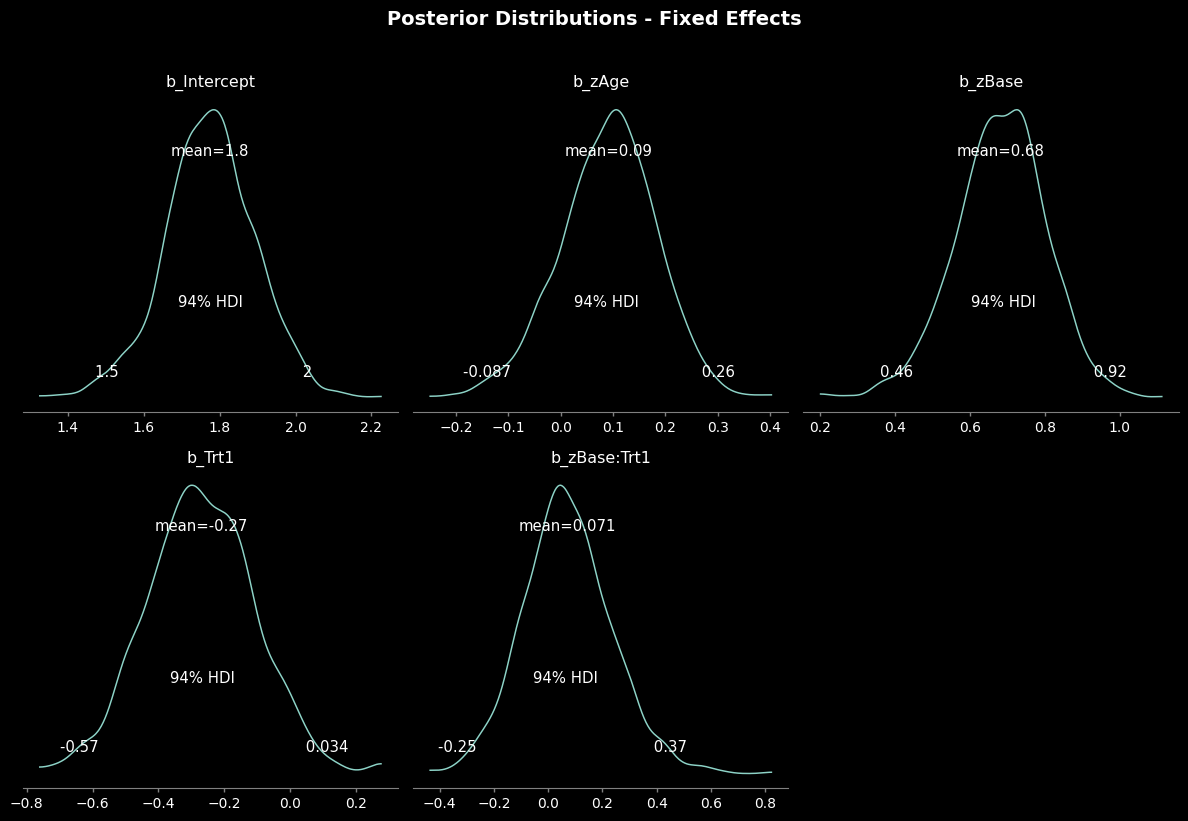

In [7]:

# Plot posterior distributions for fixed effects
fig = az.plot_posterior(
    idata,
    var_names=['b_Intercept', 'b_zAge', 'b_zBase', 'b_Trt1', 'b_zBase:Trt1'],
    figsize=(12, 8),
    textsize=10
)
plt.suptitle('Posterior Distributions - Fixed Effects', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


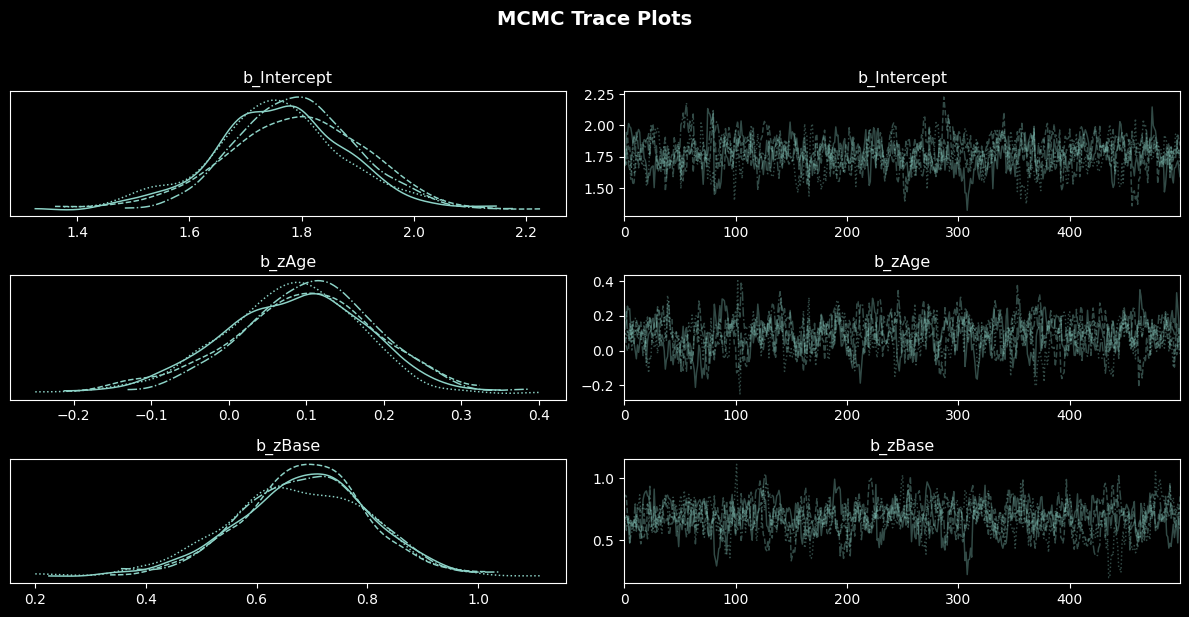

✓ Trace plots show MCMC chain behavior


In [8]:

# Trace plots to check MCMC behavior
az.plot_trace(
    idata,
    var_names=['b_Intercept', 'b_zAge', 'b_zBase'],
    figsize=(12, 6)
)
plt.suptitle('MCMC Trace Plots', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Trace plots show MCMC chain behavior")

## 6. Extract and Analyze Samples

Access the raw posterior samples for custom analysis.

Posterior Samples
Shape: (4, 500, 68)
  (chains, iterations, parameters)

Total posterior samples: 2000

b_zAge (effect of age):
  Mean: 0.0905
  Median: 0.0955
  95% CI: [-0.1058, 0.2622]


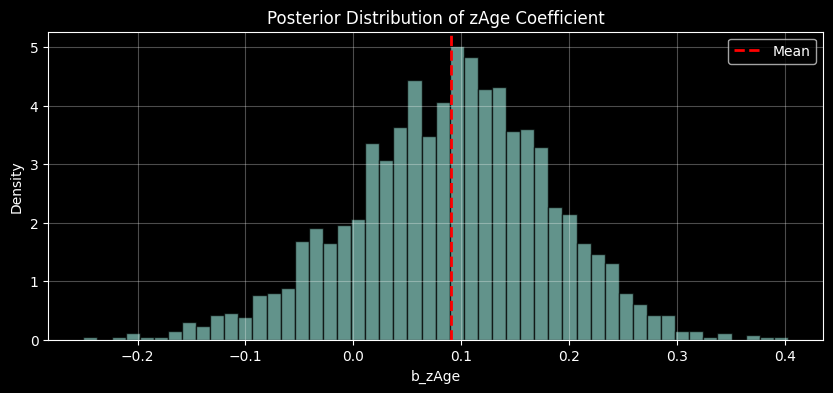

In [9]:
posterior = idata.posterior
all_draws = posterior.to_array().values   # (param, chain, draw)

# Or chain, draw, param:
all_draws_transposed = np.moveaxis(all_draws, 0, -1)

print("Posterior Samples")
print("="*60)
print(f"Shape: {all_draws_transposed.shape}")
print("  (chains, iterations, parameters)")
print(f"\nTotal posterior samples: {all_draws_transposed.shape[0] * all_draws_transposed.shape[1]}")

# Get samples for zAge coefficient
b_zAge_samples = idata.posterior['b_zAge'].values.flatten()

print(f"\nb_zAge (effect of age):")
print(f"  Mean: {b_zAge_samples.mean():.4f}")
print(f"  Median: {np.median(b_zAge_samples):.4f}")
print(f"  95% CI: [{np.percentile(b_zAge_samples, 2.5):.4f}, {np.percentile(b_zAge_samples, 97.5):.4f}]")

# Simple histogram
plt.figure(figsize=(10, 4))
plt.hist(b_zAge_samples, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(b_zAge_samples.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xlabel('b_zAge')
plt.ylabel('Density')
plt.title('Posterior Distribution of zAge Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Model with Custom Priors

Specify informative priors for better inference.

In [ ]:
# Fit model with custom priors
print("Fitting model with custom priors...\n")

model_with_priors = brmspy.fit(
    formula="count ~ zAge + zBase",
    data=epilepsy,
    family="poisson",
    priors=[
        ("normal(0, 0.5)", "b"),         # Regularizing prior on coefficients
        ("normal(1, 0.5)", "Intercept")  # Informative prior on intercept
    ],
    warmup=500,
    iter=1000,
    chains=4
)

# Get summary statistics
summary = az.summary(
    model_with_priors.idata,
    hdi_prob=0.95,          # CI width (brms defaults to 95%)
    kind="stats",           # ensures full stats like ess_bulk, r_hat, etc.
    round_to=3              # optional
)

print("Posterior Summary")
print("="*60)
print(summary)


Fitting model with custom priors...

Fitting model with brms (backend: cmdstanr)...


R callback write-console: Compiling Stan program...
  


R callback write-console: Start sampling
  


Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

## 8. Other Example Datasets

brmspy includes access to all brms datasets.

In [11]:
# Load kidney dataset
kidney = brmspy.get_brms_data("kidney")
print("Kidney Dataset")
print("="*60)
print(f"Shape: {kidney.shape}")
print(f"\nFirst few rows:")
print(kidney.head())

print("\n" + "="*60)

# Load inhaler dataset
inhaler = brmspy.get_brms_data("inhaler")
print("\nInhaler Dataset")
print("="*60)
print(f"Shape: {inhaler.shape}")
print(f"\nFirst few rows:")
print(inhaler.head())

Kidney Dataset
Shape: (76, 7)

First few rows:
    time  censored  patient recur   age     sex disease
0    8.0       0.0      1.0     1  28.0    male   other
1   23.0       0.0      2.0     1  48.0  female      GN
2   22.0       0.0      3.0     1  32.0    male   other
3  447.0       0.0      4.0     1  31.0  female   other
4   30.0       0.0      5.0     1  10.0    male   other


Inhaler Dataset
Shape: (572, 5)

First few rows:
   subject  rating  treat  period  carry
0        1     1.0    0.5     0.5    0.0
1        2     1.0    0.5     0.5    0.0
2        3     1.0    0.5     0.5    0.0
3        4     1.0    0.5     0.5    0.0
4        5     1.0    0.5     0.5    0.0
